In [ ]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")
data = dataset[0]

# Print information about the dataset
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')


Processing...


Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6
Has isolated nodes: True


Done!


<BarContainer object of 32 artists>

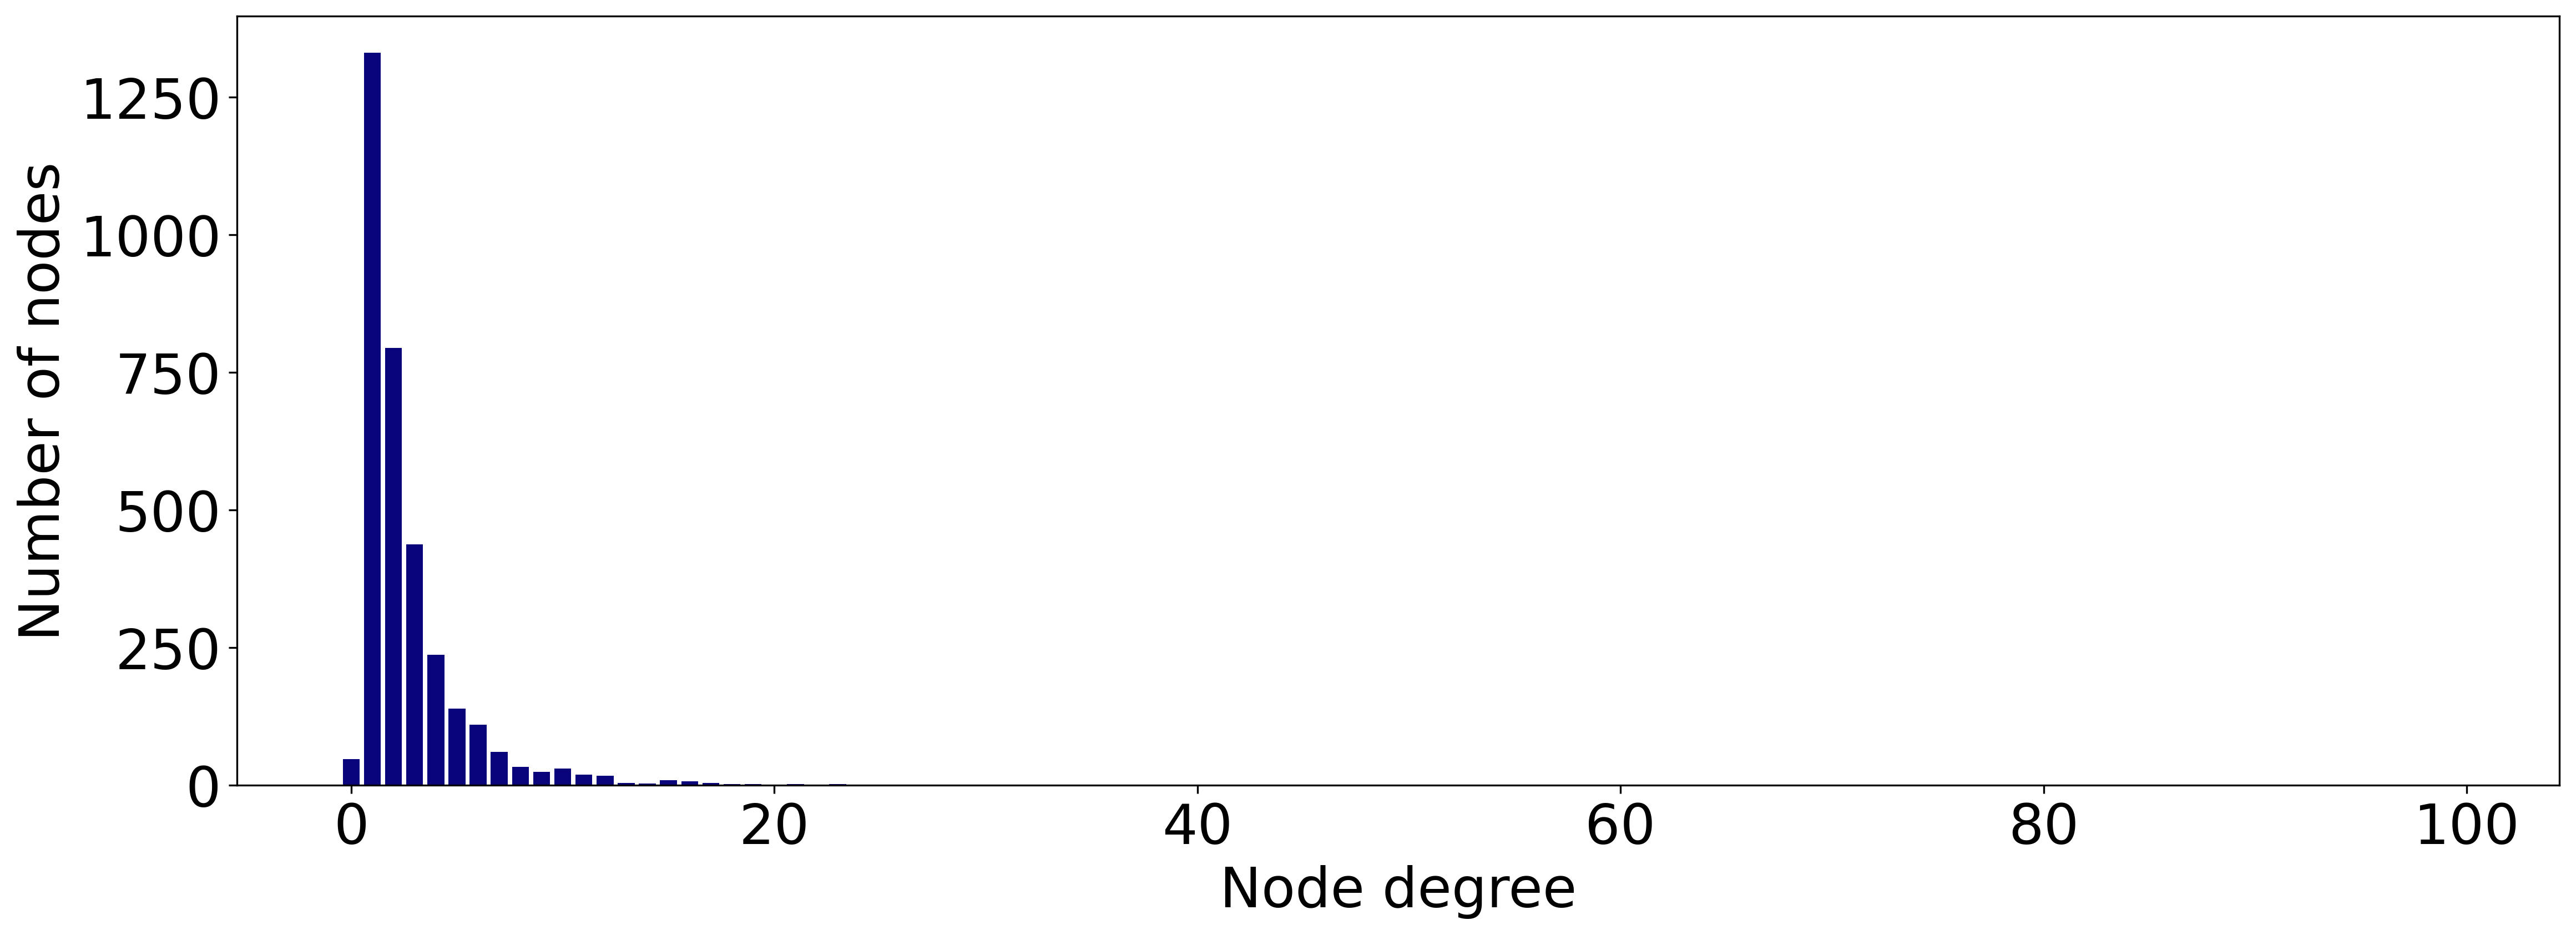

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

# Get the list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 6))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv

class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
      super().__init__()
      self.gcn1 = GCNConv(dim_in, dim_h)
      self.gcn2 = GCNConv(dim_h, dim_out)
      self.optimizer = torch.optim.Adam(self.parameters(),
                                        lr=0.01,
                                        weight_decay=5e-4)
    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index).relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(h, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200
    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
    return model

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train and test
train(gcn, data)
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

#Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train and test
train(gat, data)
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.795 | Train Acc:  14.17% | Val Loss: 1.79 | Val Acc: 18.80%
Epoch  10 | Train Loss: 0.474 | Train Acc:  95.00% | Val Loss: 1.27 | Val Acc: 57.80%
Epoch  20 | Train Loss: 0.153 | Train Acc:  97.50% | Val Loss: 1.34 | Val Acc: 56.00%
Epoch  30 | Train Loss: 0.089 | Train Acc:  98.33% | Val Loss: 1.47 | Val Acc: 58.60%
Epoch  40 | Train Loss: 0.055 | Train Acc: 100.00% | Val Loss: 1.54 | Val Acc: 56.80%
Epoch  50 | Train Loss: 0.065 | Train Acc:  98.33% | Val Loss: 1.52 | Val Acc: 58.40%
Epoch  60 | Train Loss: 0.047 | Train Acc: 100.00% | Val Loss: 1.56 | Val Acc: 57.00%
Epoch  70 | Train Loss: 0.054 | Train Acc:  99.17% | Val Loss: 1.58 | Val Acc: 54.60%
Epoch  80 | Train Loss: 0.045 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 58.20%
Epoch  90 | Train Loss: 0.066 | Train Acc:  98.33% | Val Loss: 1.50 | Val Acc: 58.60%
Epoch 100 | Train Loss: 0.024 | Train Acc: 100.00% | Val Loss: 1.61 | Val Acc: 5

En este ejemplo, podemos ver que el GAT supera al GCN en términos de precisión (67,60 % frente a 66,40 %), pero tarda más en entrenarse. Esto es una compensación que puede causar problemas de escalabilidad cuando se trabaja con gráficos grandes.

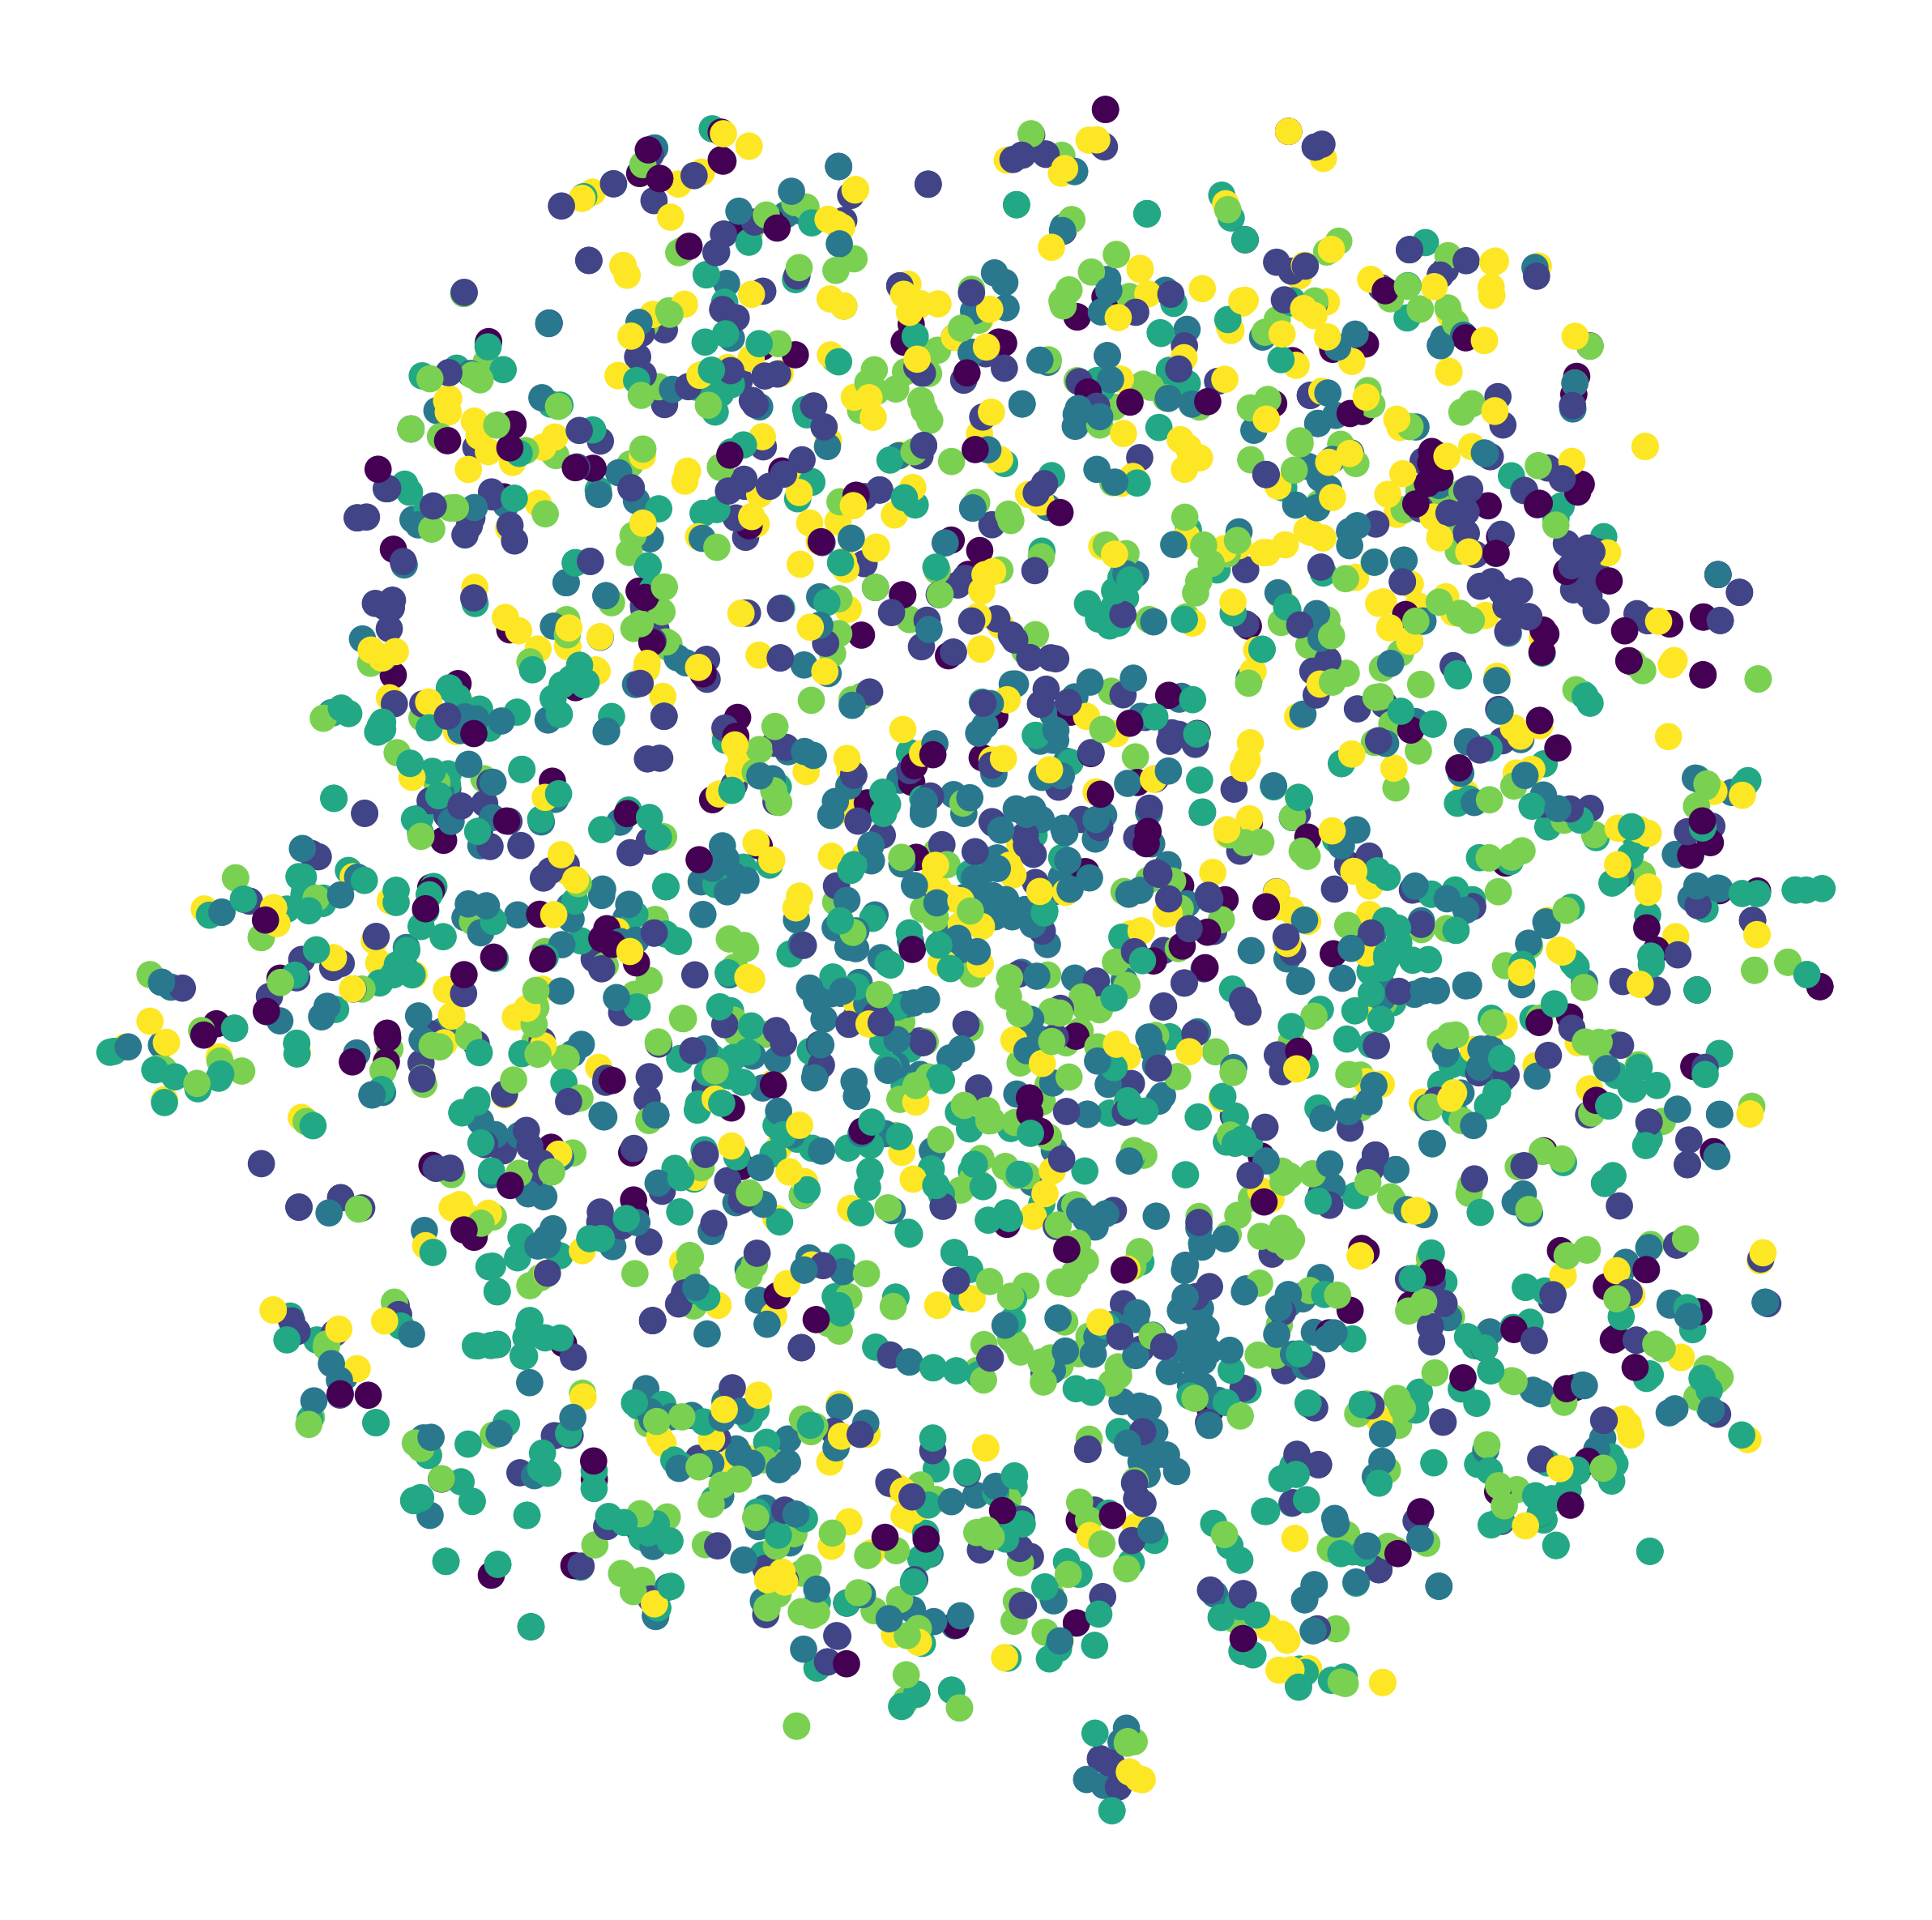

In [ ]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

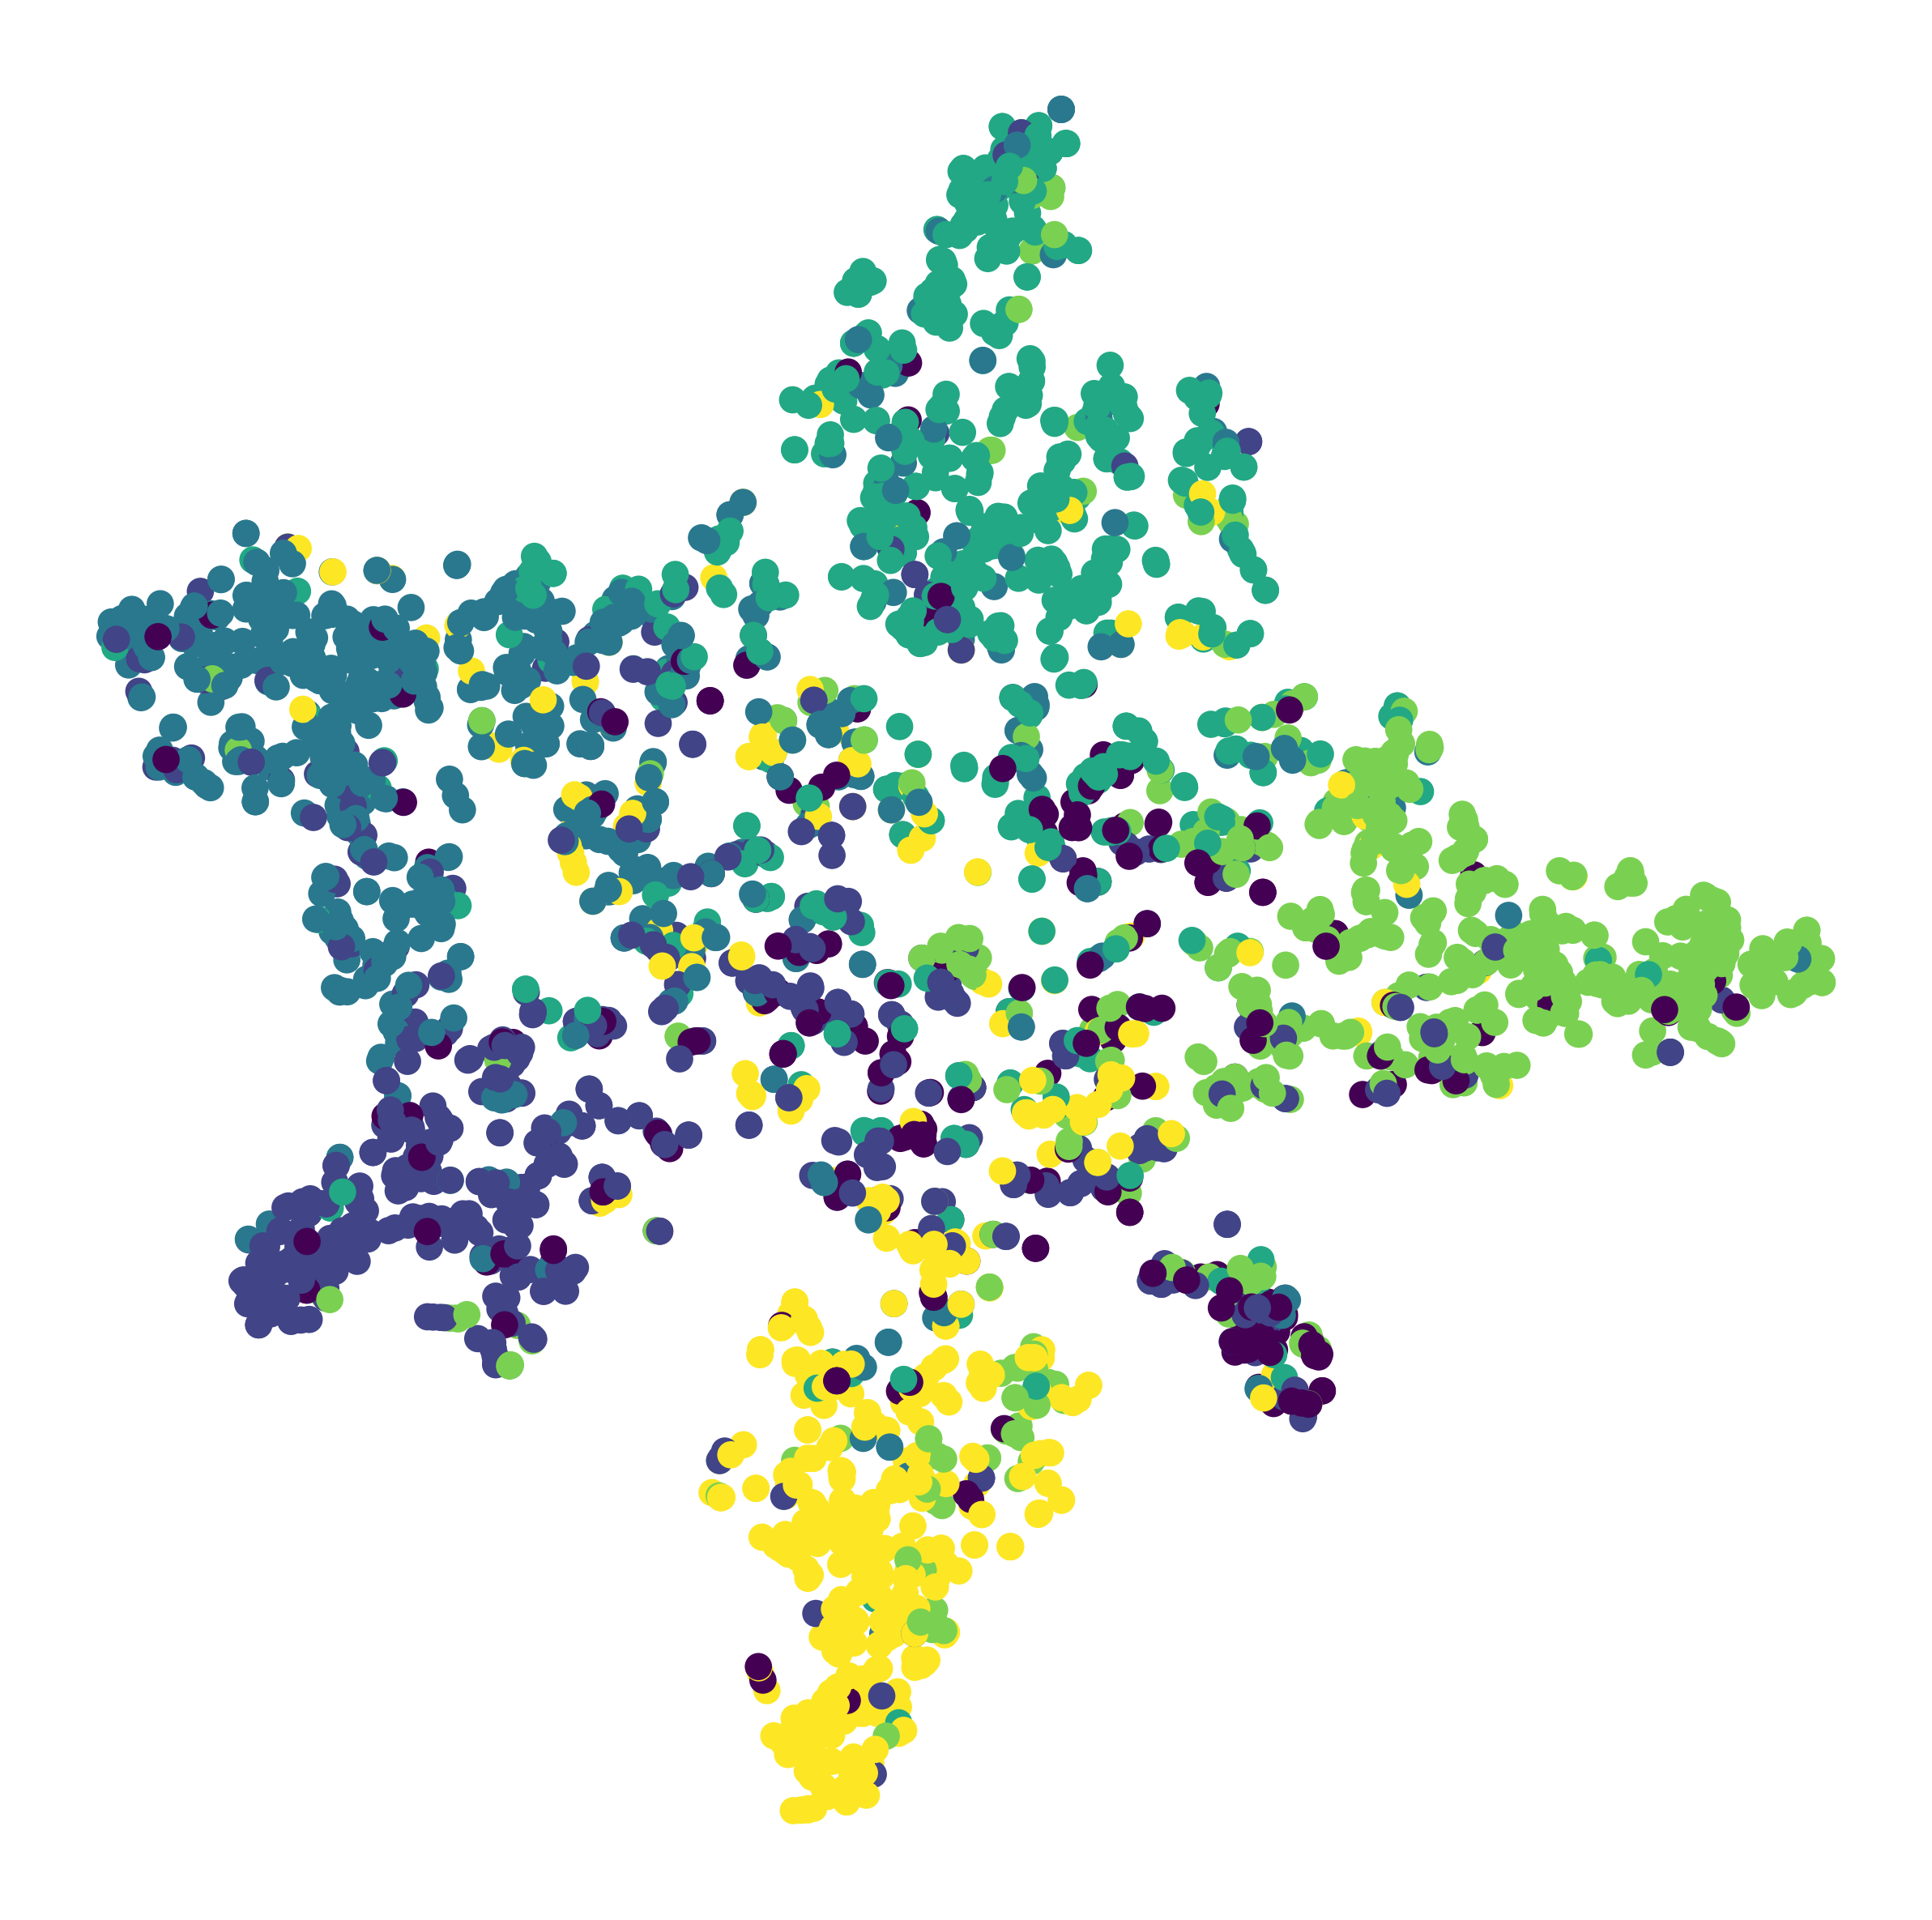

In [ ]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()


Como podemos observar la diferencia entre ambos modelos es muy notable, el modelo entrenado produce una ilustración mucho más mejorada.

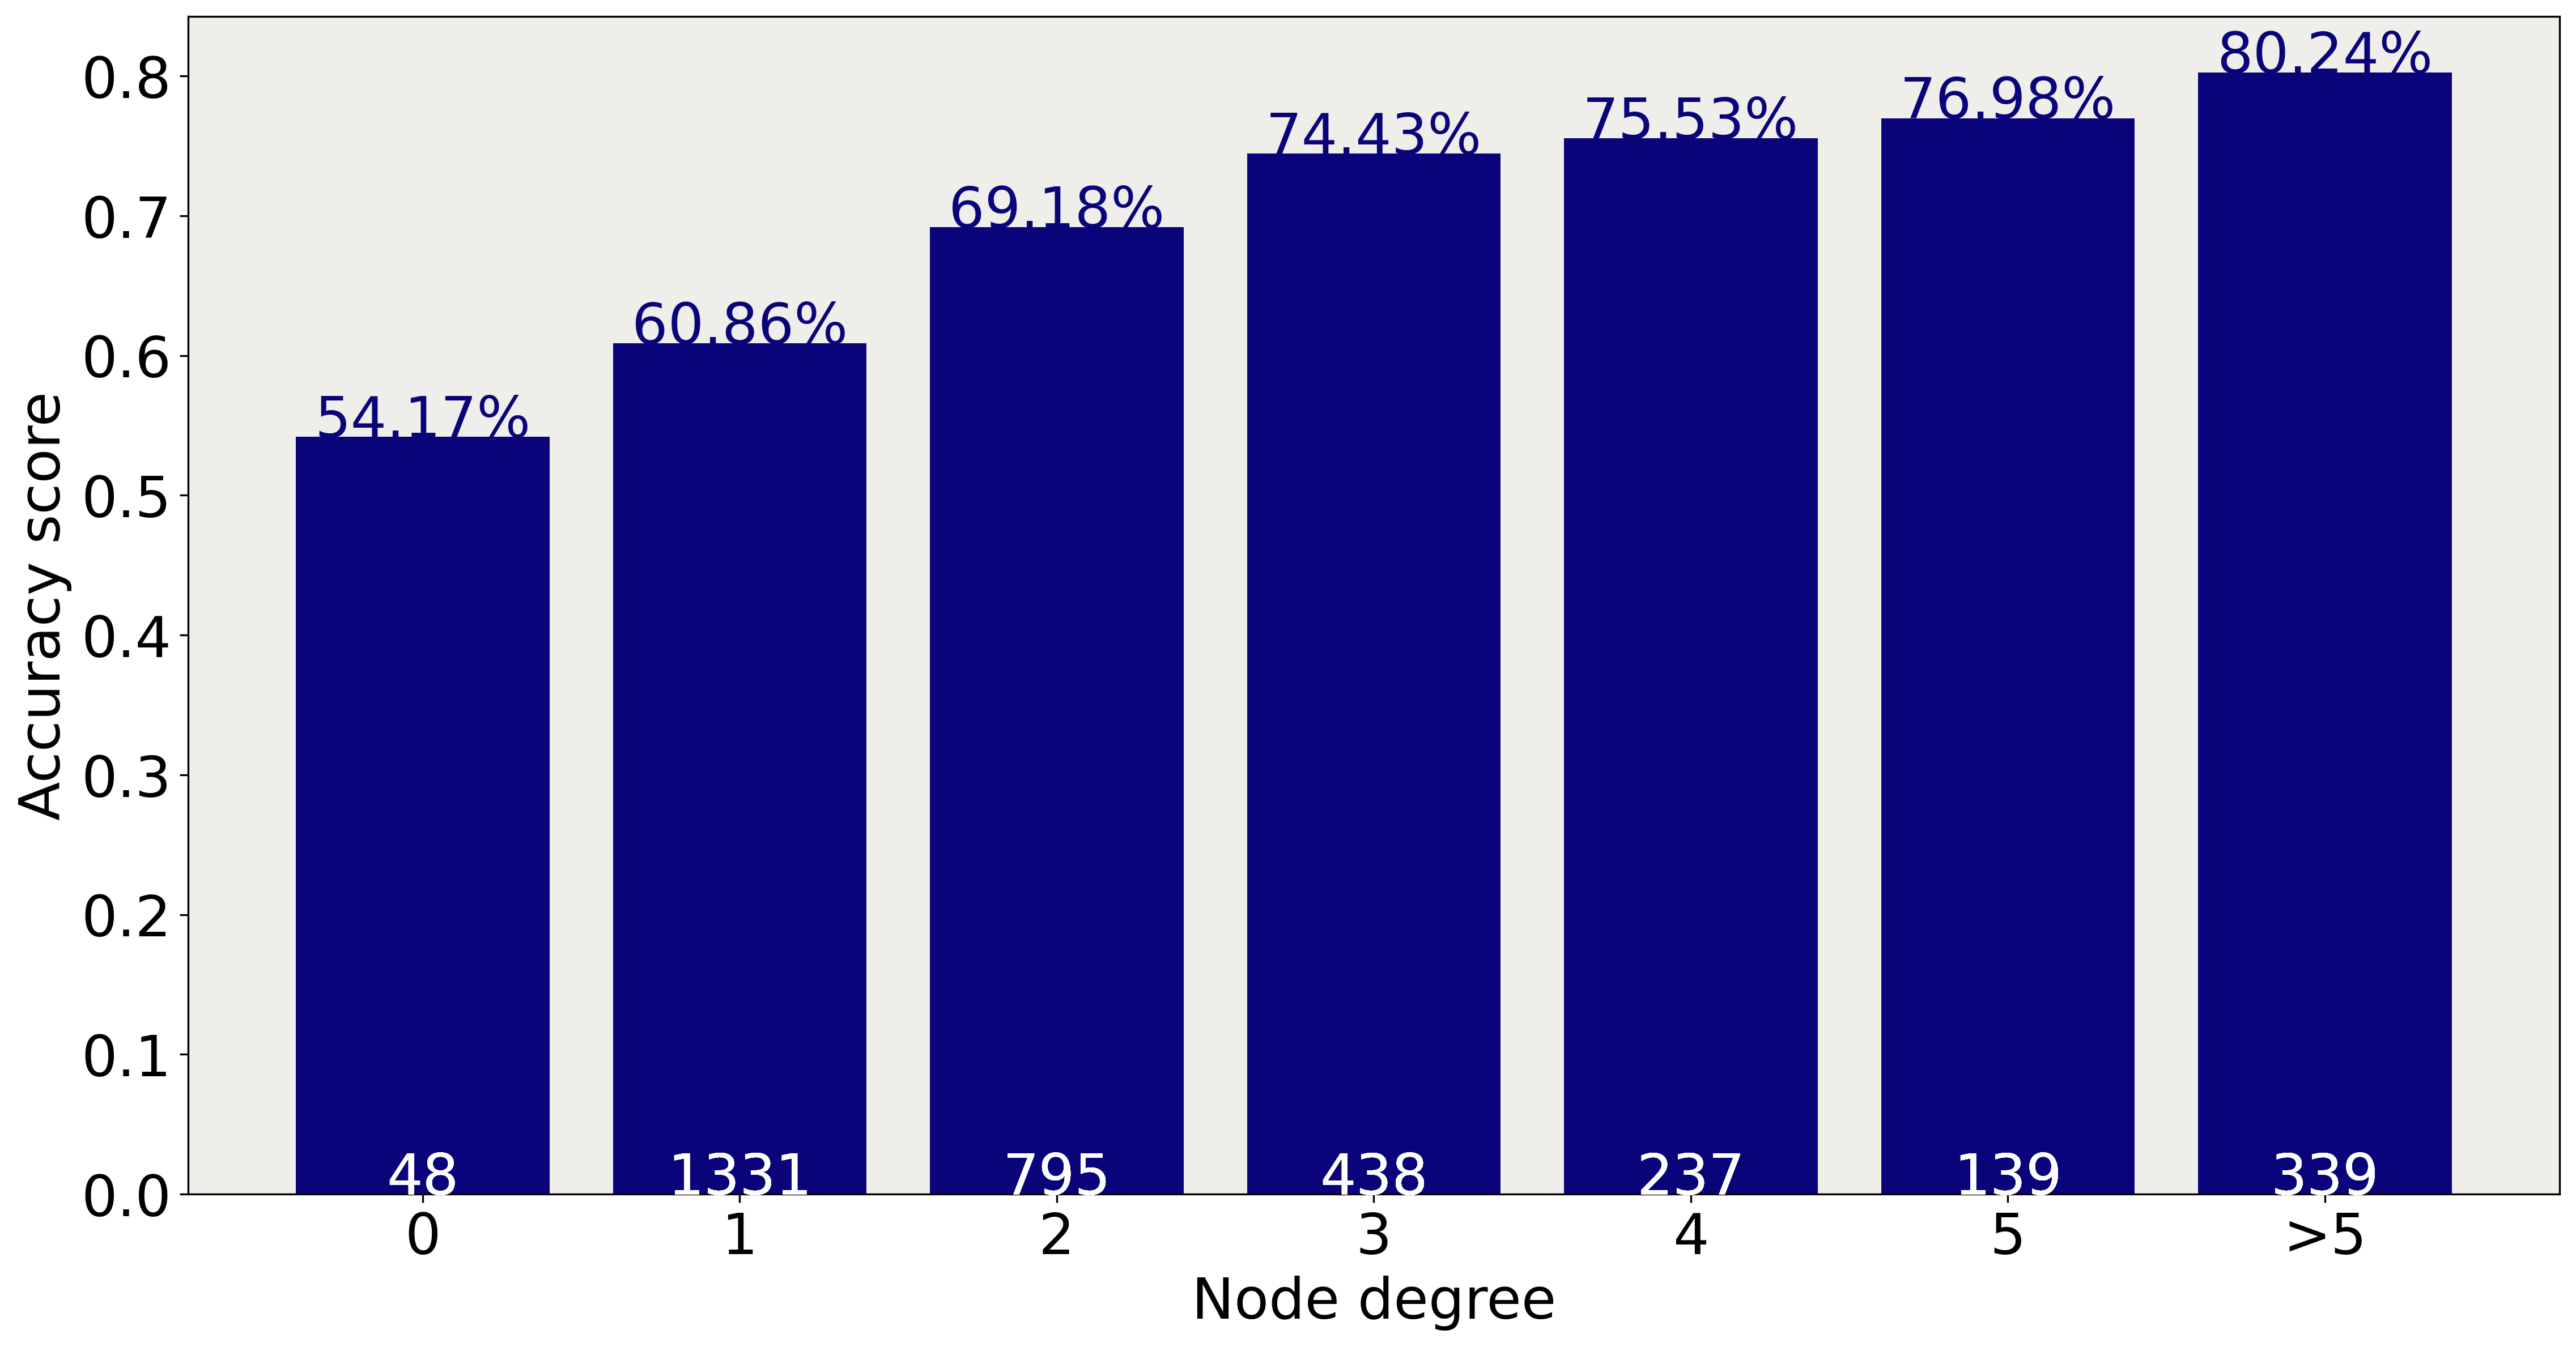

In [ ]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
ax.set_facecolor('#EFEEEA')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color='#0A047A')
    for i in range(0, 7):
      plt.text(i, accuracies[i]//2, sizes[i],
              ha='center', color='white')

Por tanto, cuantos menos vecinos tenga un nodo, más dificil será de clasificar, esto se debe a que cuantas más conexiones relevantes tenga, más información podrá agregar.

En conclusión, los GAT tienen más precisión que los GCN pero tardan más en entrenarse y el mecanismo de autoatención calcula automáticamente los pesos en lugar de los coeficientes estáticos para producir mejores incrustaciones.